# Classifying 2D data points with Multilayer Perceptron (MLP)

In [1]:
using AutoDiff
using Printf

import Plots: scatter, scatter!, plot, contourf!, display
import Distributions: Normal
import Random: shuffle, seed!
import Statistics: mean, std

seed!(42)

Random.TaskLocalRNG()

## Create the dataset

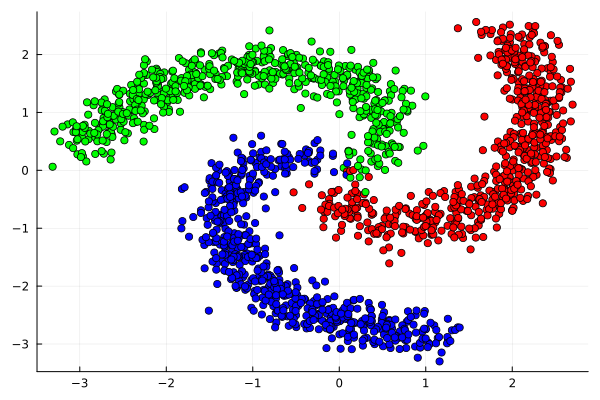

In [2]:
# The following helper code for creating dataset is generated by ChatGPT
# Helper function to create a single spiral arm
function create_spiral_arm(n_points, arm_index, n_arms, noise_level)
    # Initialize arrays
    x = zeros(n_points)
    y = zeros(n_points)
    labels = fill(arm_index, n_points)

    # Constants to control the spiral arms
    theta_offset = 2 * π * arm_index / n_arms
    max_radius = 3

    for i in 1:n_points
        # Generate points along a spiral arm
        radius = max_radius * sqrt(i / n_points)
        theta = radius + theta_offset
        x[i] = radius * cos(theta)
        y[i] = radius * sin(theta)

        # Add random noise
        x[i] += rand(Normal(0, noise_level))
        y[i] += rand(Normal(0, noise_level))
    end

    return hcat(x, y, labels)
end

n_points_per_arm = 600  # Number of points per arm
n_arms = 3              # Number of arms
noise_level = 0.2       # Noise level

# Generate the spiral data
data = vcat([create_spiral_arm(n_points_per_arm, i, n_arms, noise_level) for i in 1:n_arms]...)

# Shuffle the data
data = data[shuffle(1:end), :]

scatter(data[:, 1], data[:, 2], marker_z=data[:, 3], color=:brg, legend=false)

## Preprocess the dataset

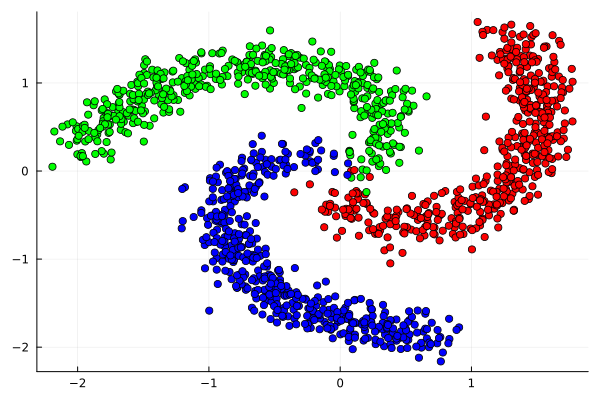

In [3]:
function split_data(data, train_ratio)
    # Calculate the number of training examples
    n = size(data, 1)
    n_train = round(Int, n * train_ratio)

    # Shuffle the indices
    indices = shuffle(1:n)

    # Split the indices for the training and validation set
    train_indices = indices[1:n_train]
    val_indices = indices[n_train+1:end]

    # Create the training and validation sets
    train_data = data[train_indices, :]
    val_data = data[val_indices, :]

    return train_data, val_data
end

# split into train/validation sets
train_data, val_data = split_data(data, 0.8)

# split into data/labels
train_data, train_labels = train_data[:, 1:2], train_data[:, 3]
val_data, val_labels = val_data[:, 1:2], val_data[:, 3]

# convert labels to integers
train_labels = Int8.(train_labels)
val_labels = Int8.(val_labels)

# normalize the data
train_mean = mean(train_data, dims=1)
train_std = std(train_data, dims=1)
train_data = (train_data .- train_mean) ./ train_std

# do not forget to normalize validation data as well (using the same normalizing constants)
val_data = (val_data .- train_mean) ./ train_std

# add bias to the created training data
train_data = hcat(train_data, ones(size(train_data, 1)))
val_data = hcat(val_data, ones(size(val_data, 1)))

# transpose the data points
train_data = transpose(train_data)
val_data = transpose(val_data)

# view the training set
scatter(train_data[1, :], train_data[2, :], marker_z=train_labels, color=:brg, legend=false)

## Train the classifier with AutoDiff engine

In [4]:
# define the model with three linear layers
model = Sequential(
    Linear(3, 256),
    ReLU(),
    Linear(256, 3),
)

Sequential(AutoDiff.Layer[Linear 3 => 256, ReLU, Linear 256 => 3])

In [5]:
function predict(model, x)
    logits = model(Tensor(x))
    logits = logits.data
    preds = [index[1] for index in argmax(logits, dims=1)]
    preds = dropdims(preds, dims=1)
    return preds
end

n_epochs = 500
lr = 1.0  # learning rate

lossval = nothing
for epoch in 1:n_epochs
    x = Tensor(train_data)
    loss = CEloss(model(x), train_labels)
    lossval = only(loss.data)

    zero_grad!!(loss)
    backward(loss)
    AutoDiff.step(loss; lr)
end

preds = predict(model, val_data)
error = mean(preds .!= val_labels) * 100
fmt(x) = @sprintf("%.2f", x)
println("Finished training, n_epochs = $n_epochs")
println("Loss = $(fmt(lossval)), error = $(fmt(error))%")

Finished training, n_epochs = 500
Loss = 0.02, error = 0.83%


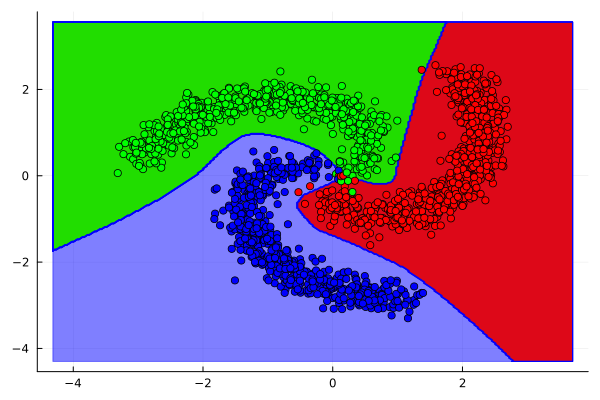

In [6]:
# Create a grid of points to evaluate
x_min, x_max = extrema(data[:, 1]) .+ (-1, 1)
y_min, y_max = extrema(data[:, 2]) .+ (-1, 1)
grid_x, grid_y = range(x_min, x_max, length=300), range(y_min, y_max, length=300)

grid = [[x, y] for x in grid_x, y in grid_y]
grid = hcat(grid...)
grid = (grid .- train_mean') ./ train_std'
grid = vcat(grid, ones(Float64, (1, size(grid, 2))))

# Predict the function value for the whole grid
predictions = predict(model, grid)

# Convert predictions to a format that can be plotted
pred_matrix = reshape(predictions, length(grid_x), length(grid_y))

# Create the plot
p = plot()

# Plot the decision boundaries
contourf!(p, grid_x, grid_y, pred_matrix', alpha=0.5, color=:brg, colorbar=false)

# Overlay the data points, using different colors for different classes
scatter!(p, data[:, 1], data[:, 2], marker_z=data[:, 3], color=:brg, legend=false)

# Display the plot
display(p)